In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis Function

In [26]:
def scale_data(data, avoiding_columns):
    excluded_data = data[avoiding_columns]
    data = data.drop(avoiding_columns, axis=1)
    
    # Scale the data using standardization    
    scaler = MinMaxScaler()        
    scaled_data = scaler.fit_transform(data)
    
    # Convert the scaled data back to a DataFrame
    scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
    scaled_data = pd.concat([scaled_data, excluded_data], axis=1)
    return scaled_data


In [27]:
def brainwave_mean_amplitude(data, target):    
    movement_class = data[target]
    data = data.iloc[:, :112]

    # Get unique class labels
    class_labels = movement_class.unique()

    # Calculate the mean of each column for each class
    means = []
    for label in class_labels:
        class_data = data[movement_class == label]
        class_means = class_data.median()
        means.append(class_means)

    # Create a horizontal bar chart with four data points in each bin
    num_columns = data.shape[1]
    y = np.arange(num_columns)
    height = 0.2

    plt.figure(figsize=(10, 25))
    for i, class_mean in enumerate(means):
        plt.barh(y + (i * height), class_mean, height=height, label=f'{class_labels[i]}')

    plt.ylabel('Brain Wave Columns')
    plt.xlabel('Median Amplitude')
    plt.title('Median Amplitude of Brain Wave Columns for Each Class')
    plt.yticks(y + ((len(class_labels) - 1) * height / 2), data.columns)
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig1.png")
    plt.show()


In [28]:
def grouped_count(data, target):
    grouped_counts = data.groupby(target).size().reset_index(name='Count')

    # Display the result
    print(grouped_counts)

In [29]:
def correlation_analysis(data):
    # Calculate the correlations between variables
    corr = data.corr()
    top_correlations = corr.unstack()
    top_correlations = top_correlations[top_correlations.index.get_level_values(0) != top_correlations.index.get_level_values(1)]
    top_correlations = top_correlations.sort_values(ascending=False)[:50]
    print("Top correlations between the target variables:")
    print(top_correlations)

# Model Building Helper Functions

In [30]:
# Preprocess the inputs and split the data into train and test sets
def preprocess_inputs(df, target):
    df = df.copy()
    
    y = df[target].copy()
    X = df.drop(target, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    return X_train, X_test, y_train, y_test

In [31]:
# Build the neural network model
def build_model(num_classes, neurons, X_train):
    inputs = tf.keras.Input(shape=(X_train.shape[1]))
    x = tf.keras.layers.Dense(neurons, activation='relu')(inputs)
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [32]:
# Plot the training and validation accuracy
def plot_results(model, history, X_test, y_test):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot the accuracy graph
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy of Neural Network Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate classification report and confusion matrix
    report = classification_report(y_test, y_pred_classes)
    print("Classification Report:")
    print(report)

    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig("fig.png")
    plt.show()
    
    
    acc = model.evaluate(X_test, y_test)[1]
    print(f'Test Accuracy: {acc*100:.4f}')

In [33]:
def build_and_fit_model(data, target, neurons):
    # Preprocess the data
    X_train, X_test, y_train, y_test = preprocess_inputs(data, target)

    # Build and train the model
    model = build_model(num_classes=data[target].nunique(), neurons=neurons, X_train=X_train)
    history = model.fit(X_train,
                             y_train,
                             validation_split = 0.2,
                             batch_size = 32,
                             epochs = 50,
                            callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ])

    # Evaluate the model
    plot_results(model, history, X_test, y_test)

# Case 1: Hands Movement

In [34]:
# Read the CSV files for each user and store them in a list
data = [pd.read_csv("../input/eeg-data-from-hands-movement/Dataset/user_" + user + ".csv") for user in ['a', 'b', 'c', 'd']]

In [35]:
for i in range(len(data)):
    data[i]['User'] = pd.Series(i, index = data[i].index)

In [36]:
# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(data, axis=0)
data = data.sample(frac=1.0, random_state=123)  # Shuffle the data
data = data.reset_index(drop=True)

data = scale_data(data, ["Class", "User"])
data

,AF3 delta std,AF3 delta m,AF3 theta std,AF3 theta m,AF3 alpha std,AF3 alpha m,AF3 beta std,AF3 beta m,F7 delta std,F7 delta m,...,AF4 delta std,AF4 delta m,AF4 theta std,AF4 theta m,AF4 alpha std,AF4 alpha m,AF4 beta std,AF4 beta m,Class,User
0,0.568277,0.409038,0.054140,0.052791,0.065302,0.094678,0.313560,0.343898,0.289335,0.193157,...,0.876818,0.119994,0.055528,0.071357,0.080810,0.212905,0.488260,0.457872,0.0,0
1,0.573529,0.411277,0.125349,0.095657,0.119535,0.086696,0.342578,0.444804,0.247403,0.225810,...,0.926154,0.134472,0.112727,0.149794,0.135256,0.170903,0.265903,0.513134,1.0,0
2,0.518215,0.367084,0.059622,0.111547,0.074706,0.102024,0.565462,0.568415,0.412661,0.211742,...,0.791213,0.071293,0.056919,0.052148,0.006576,0.044375,0.011068,0.029914,0.0,2
3,0.563813,0.403906,0.121586,0.085793,0.094098,0.117693,0.126075,0.265522,0.308275,0.165597,...,0.854176,0.112664,0.162871,0.065477,0.237475,0.333865,0.362592,0.747762,0.0,0
4,0.533037,0.372712,0.067442,0.035380,0.170307,0.107092,0.424324,0.509015,0.558821,0.314764,...,0.767357,0.020200,0.014735,0.010390,0.004657,0.019577,0.004911,0.008056,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,0.564038,0.400234,0.045955,0.031143,0.103656,0.096892,0.092004,0.114535,0.222960,0.141284,...,0.819096,0.052682,0.017806,0.006561,0.012698,0.008607,0.009276,0.006959,2.0,3
11516,0.552350,0.396605,0.096309,0.085286,0.141880,0.106133,0.741190,0.433227,0.635851,0.335885,...,0.800650,0.045394,0.018211,0.011770,0.008131,0.009023,0.019838,0.020900,1.0,2
11517,0.573729,0.406292,0.044842,0.035524,0.076160,0.072258,0.333031,0.143084,0.338498,0.191006,...,0.823470,0.053671,0.012779,0.008409,0.008946,0.008382,0.012201,0.006531,0.0,1
11518,0.574169,0.413500,0.037969,0.079280,0.061420,0.033862,0.560824,0.301854,0.342238,0.180137,...,0.857781,0.081535,0.014985,0.013647,0.034301,0.027078,0.376612,0.191480,0.0,0


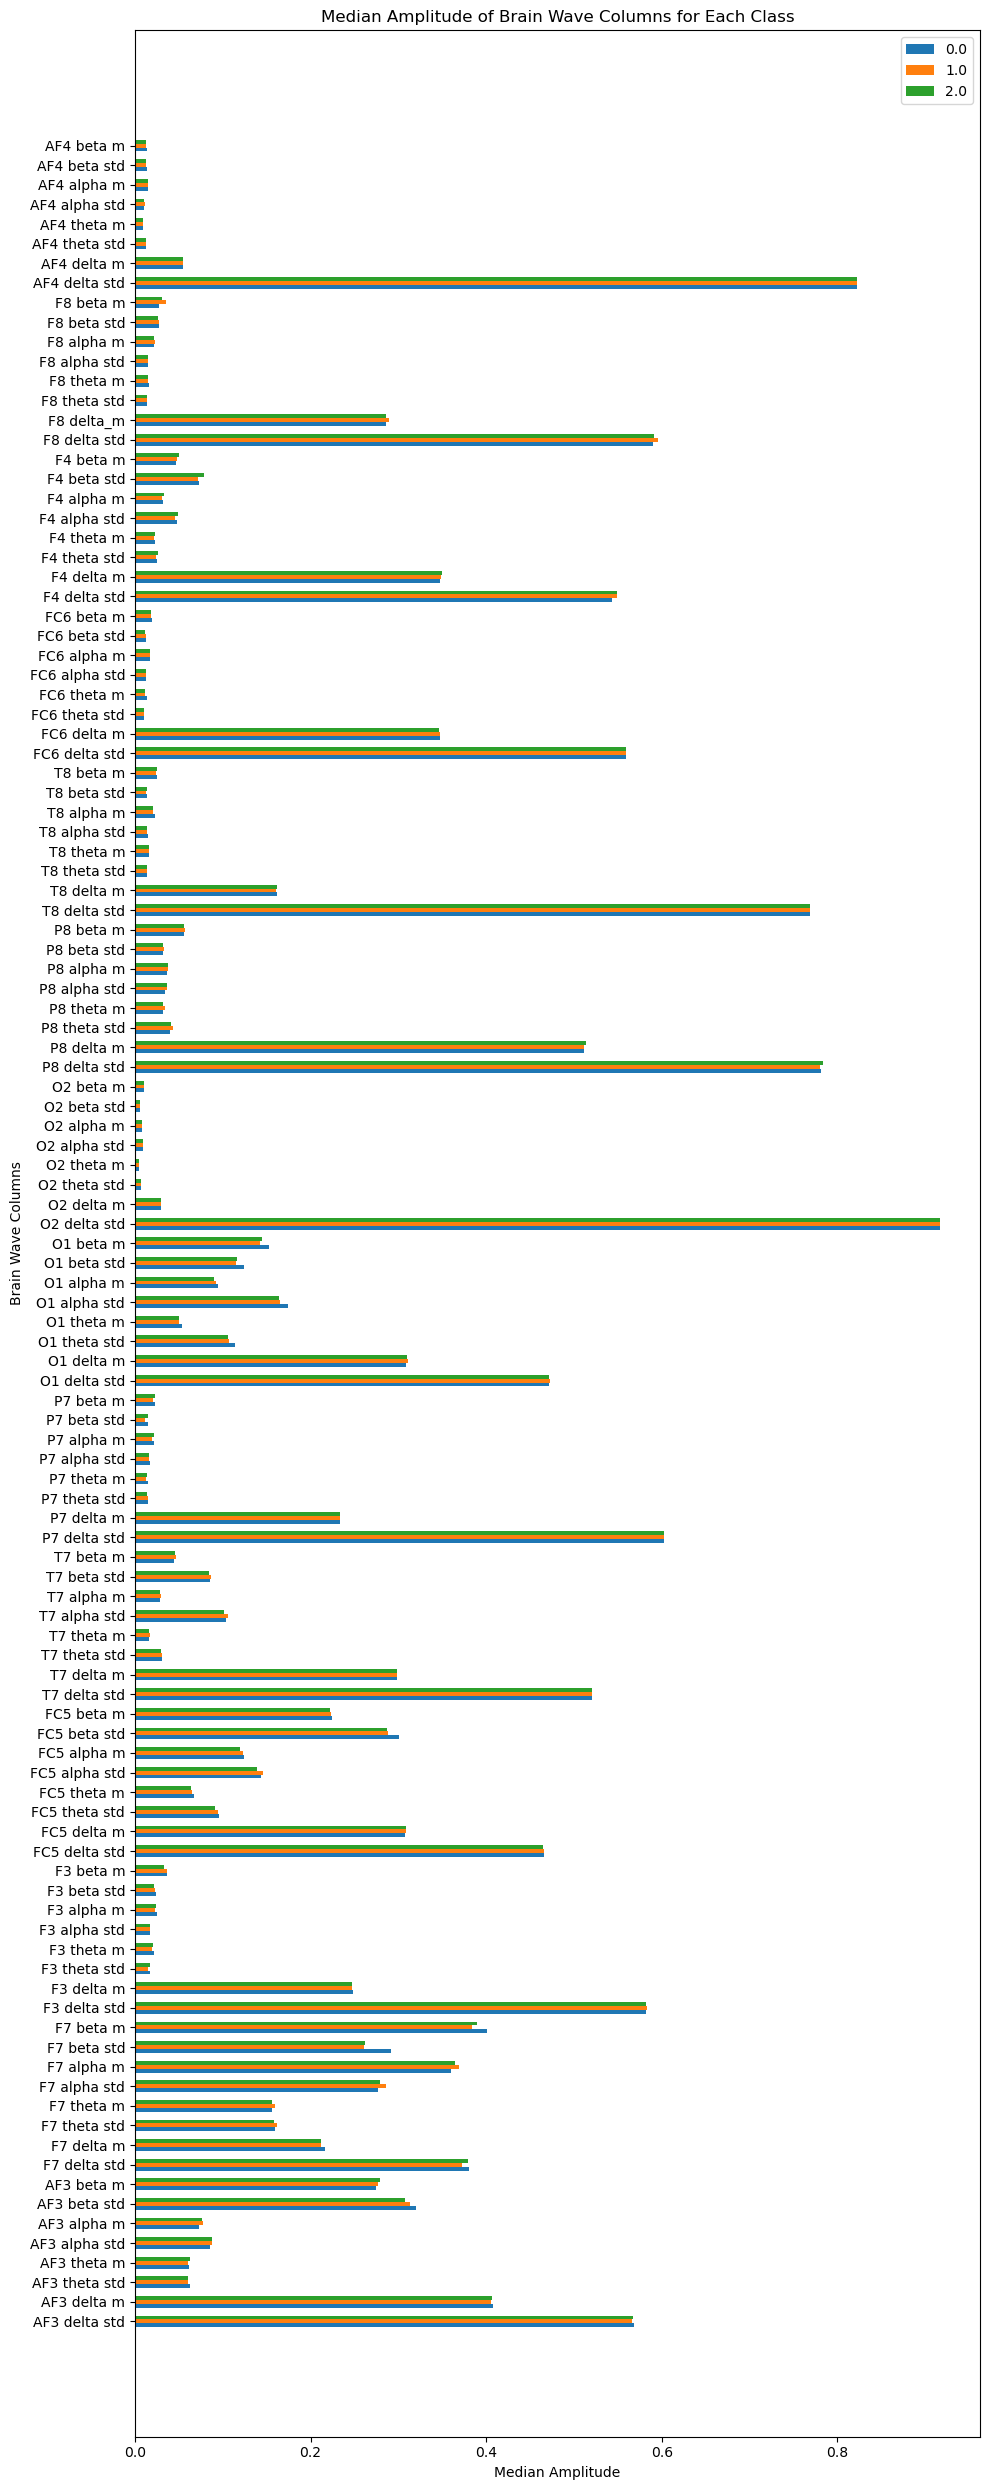

In [37]:
brainwave_mean_amplitude(data, "Class")

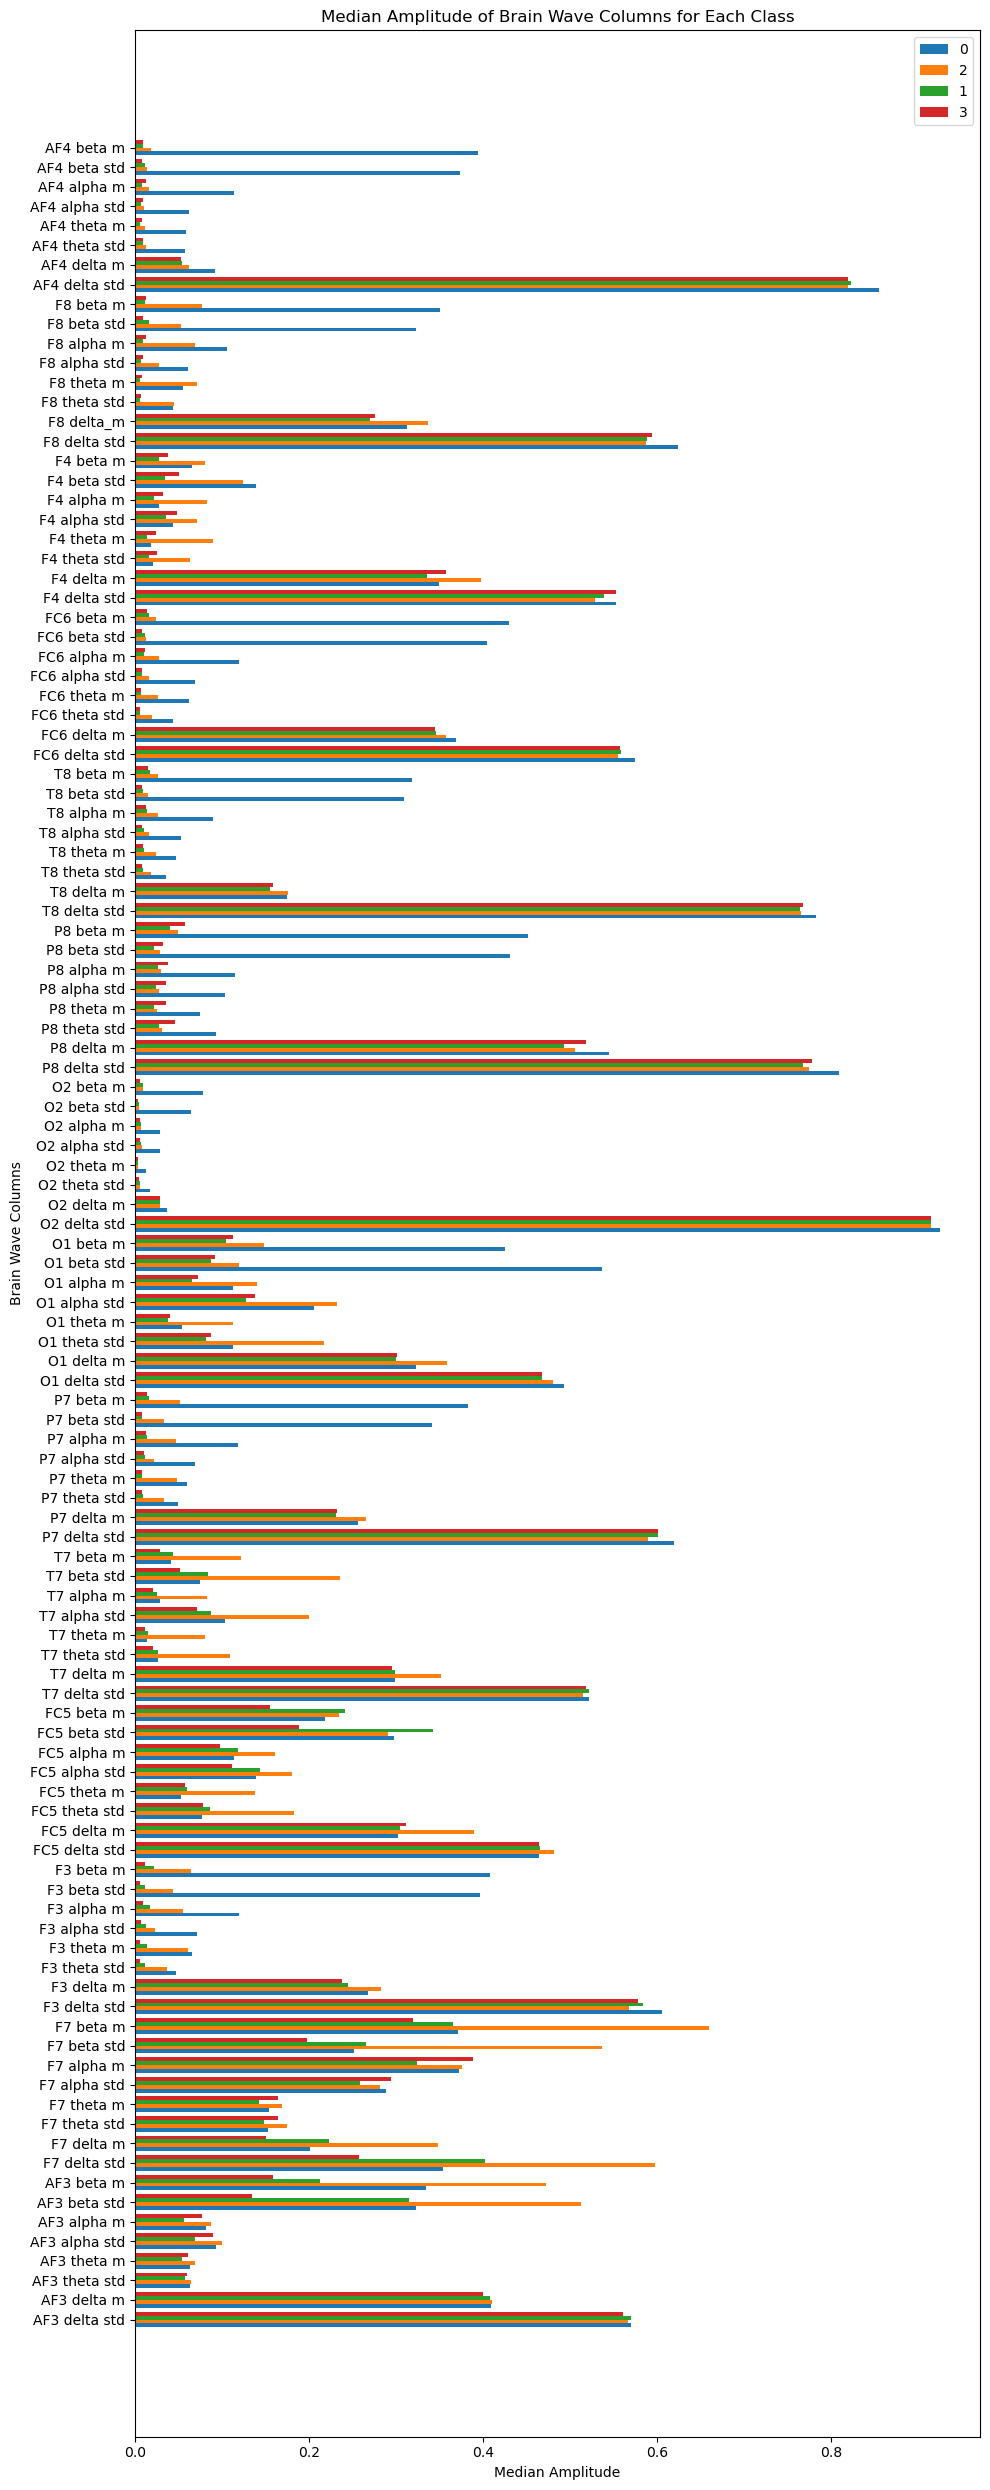

In [38]:
brainwave_mean_amplitude(data, "User")

In [39]:
grouped_count(data, "Class")

   Class  Count
0    0.0   3840
1    1.0   3840
2    2.0   3840


In [40]:
grouped_count(data, "User")

   User  Count
0     0   2880
1     1   2880
2     2   2880
3     3   2880


In [41]:
correlation_analysis(data)

Top correlations between the target variables:
AF4 beta std  FC6 beta std    0.997765
FC6 beta std  AF4 beta std    0.997765
AF4 beta std  P7 beta std     0.996561
P7 beta std   AF4 beta std    0.996561
AF4 beta std  F3 beta std     0.996010
F3 beta std   AF4 beta std    0.996010
P7 beta std   F8 beta std     0.995794
F8 beta std   P7 beta std     0.995794
F3 beta std   P7 beta std     0.995776
P7 beta std   F3 beta std     0.995776
FC6 beta std  F3 beta std     0.995673
F3 beta std   FC6 beta std    0.995673
FC6 beta std  P7 beta std     0.995261
P7 beta std   FC6 beta std    0.995261
FC6 beta m    AF4 beta m      0.994783
AF4 beta m    FC6 beta m      0.994783
T8 beta std   P7 beta std     0.994596
P7 beta std   T8 beta std     0.994596
F8 beta std   T8 beta std     0.992926
T8 beta std   F8 beta std     0.992926
AF4 beta std  T8 beta std     0.992485
T8 beta std   AF4 beta std    0.992485
              FC6 beta std    0.992176
FC6 beta std  T8 beta std     0.992176
F3 beta std   F8 

Epoch 1/50
202/202 [==============================] - 1s 4ms/step - loss: 1.0714 - accuracy: 0.4208 - val_loss: 1.0547 - val_accuracy: 0.4334
Epoch 2/50
202/202 [==============================] - 0s 2ms/step - loss: 0.9867 - accuracy: 0.4940 - val_loss: 0.9838 - val_accuracy: 0.5040
Epoch 3/50
202/202 [==============================] - 0s 2ms/step - loss: 0.9261 - accuracy: 0.5457 - val_loss: 0.9397 - val_accuracy: 0.5418
Epoch 4/50
202/202 [==============================] - 0s 2ms/step - loss: 0.8802 - accuracy: 0.5816 - val_loss: 0.9251 - val_accuracy: 0.5499
Epoch 5/50
202/202 [==============================] - 0s 2ms/step - loss: 0.8417 - accuracy: 0.6095 - val_loss: 0.8915 - val_accuracy: 0.5735
Epoch 6/50
202/202 [==============================] - 0s 2ms/step - loss: 0.7943 - accuracy: 0.6375 - val_loss: 0.8891 - val_accuracy: 0.5834
Epoch 7/50
202/202 [==============================] - 1s 3ms/step - loss: 0.7453 - accuracy: 0.6643 - val_loss: 0.8909 - val_accuracy: 0.5790
Epoch 

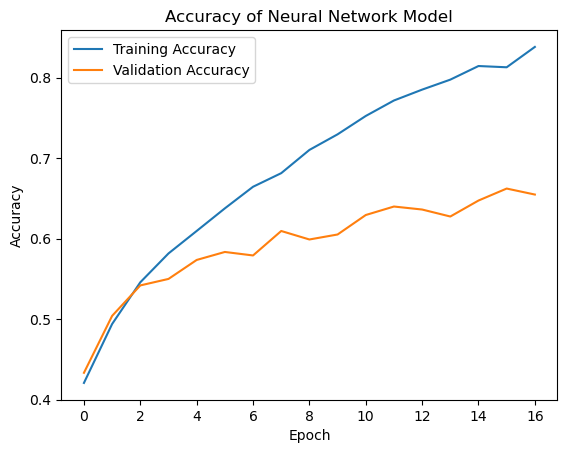

109/109 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.65      1142
         1.0       0.65      0.57      0.61      1191
         2.0       0.58      0.67      0.62      1124

    accuracy                           0.63      3457
   macro avg       0.63      0.63      0.63      3457
weighted avg       0.63      0.63      0.63      3457



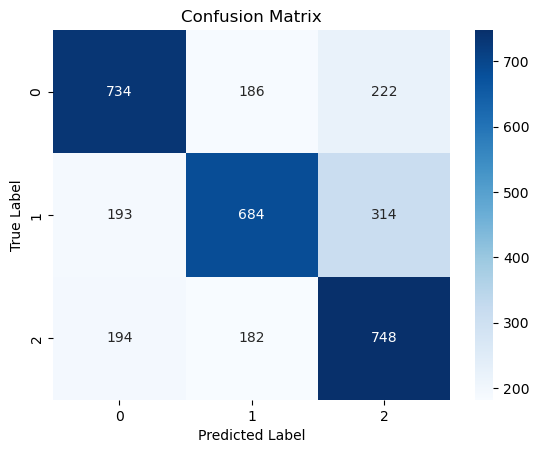

109/109 [==============================] - 0s 1ms/step - loss: 0.8538 - accuracy: 0.6266
Test Accuracy: 62.6555


In [42]:
build_and_fit_model(data, "Class", 128)

Epoch 1/50
202/202 [==============================] - 1s 3ms/step - loss: 0.1372 - accuracy: 0.9581 - val_loss: 0.0242 - val_accuracy: 0.9950
Epoch 2/50
202/202 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.9961 - val_loss: 0.0101 - val_accuracy: 0.9963
Epoch 3/50
202/202 [==============================] - 1s 3ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0056 - val_accuracy: 0.9981
Epoch 4/50
202/202 [==============================] - 1s 3ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0172 - val_accuracy: 0.9932
Epoch 5/50
202/202 [==============================] - 1s 3ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 6/50
202/202 [==============================] - 0s 2ms/step - loss: 7.6593e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 7/50
202/202 [==============================] - 1s 3ms/step - loss: 4.8917e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.999

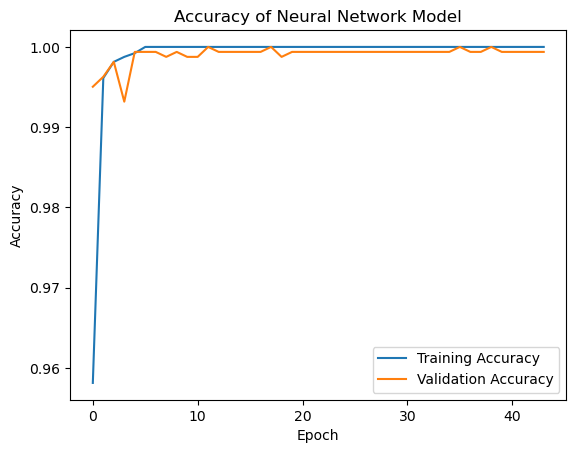

109/109 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       880
           1       1.00      1.00      1.00       857
           2       1.00      1.00      1.00       872
           3       1.00      1.00      1.00       848

    accuracy                           1.00      3457
   macro avg       1.00      1.00      1.00      3457
weighted avg       1.00      1.00      1.00      3457



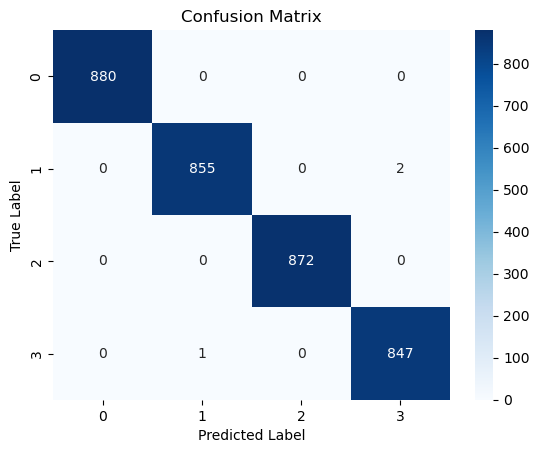

109/109 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9991
Test Accuracy: 99.9132


In [43]:
build_and_fit_model(data, "User", 128)

# Case 2: Eye State

In [44]:
# Read the CSV files for each user and store them in a list
data = pd.read_csv("/kaggle/input/eye-state-classification-eeg-dataset/EEG_Eye_State_Classification.csv")

In [45]:
data.rename(columns={'eyeDetection': 'State'}, inplace=True)
data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,State
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1


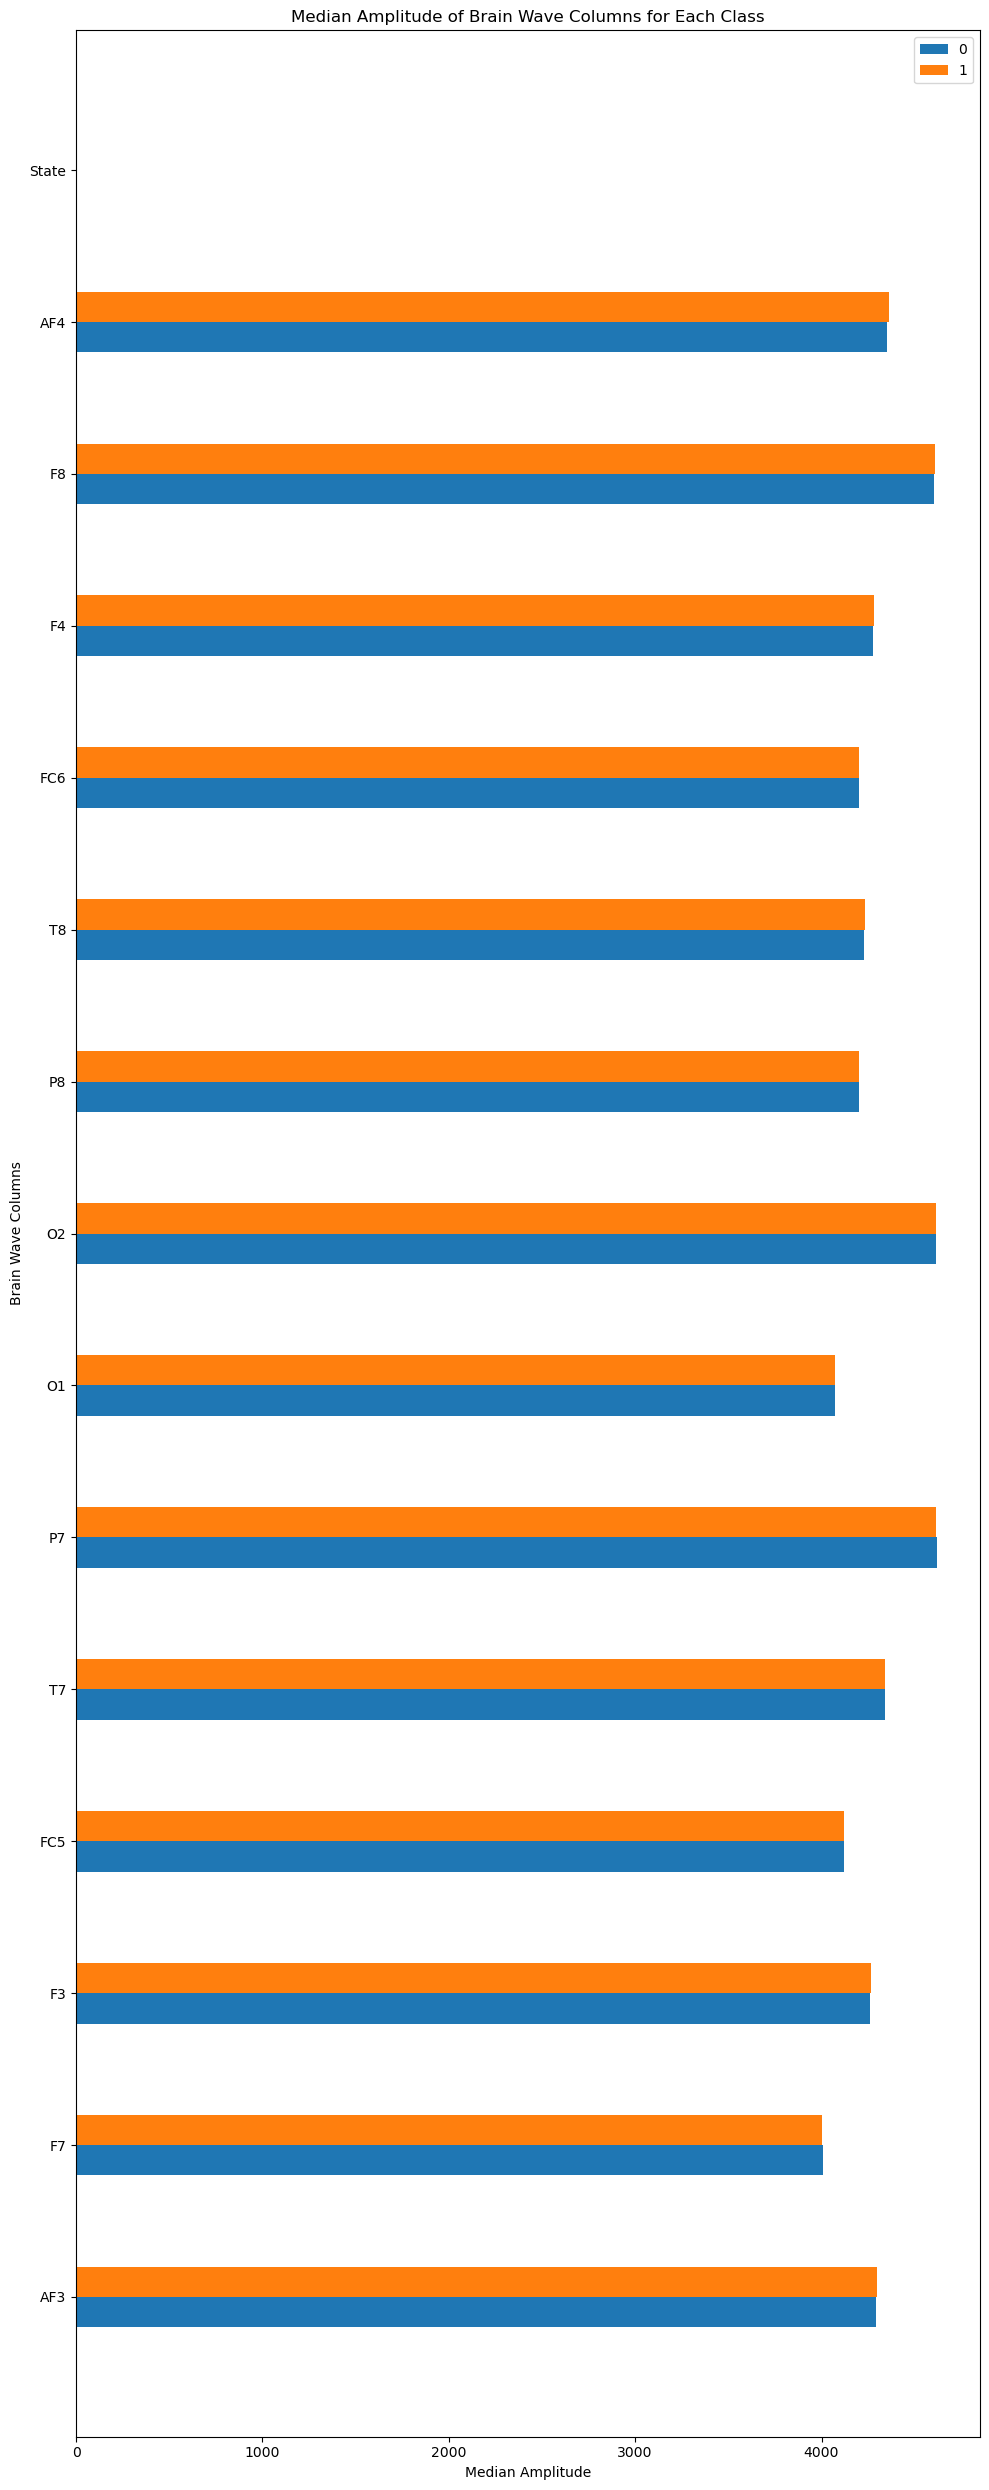

In [46]:
brainwave_mean_amplitude(data, "State")

In [47]:
grouped_count(data, "State")

   State  Count
0      0   8257
1      1   6723


In [48]:
correlation_analysis(data)

Top correlations between the target variables:
FC5  O1     0.999961
O1   FC5    0.999961
P8   AF3    0.999607
AF3  P8     0.999607
P8   F8     0.998849
F8   P8     0.998849
AF3  F8     0.998714
F8   AF3    0.998714
P7   AF4    0.988310
AF4  P7     0.988310
T8   O2     0.640387
O2   T8     0.640387
F7   F3     0.583317
F3   F7     0.583317
P8   FC6    0.577472
FC6  P8     0.577472
F8   FC6    0.577408
FC6  F8     0.577408
O2   F4     0.577013
F4   O2     0.577013
FC6  AF3    0.572997
AF3  FC6    0.572997
F3   FC6    0.517950
FC6  F3     0.517950
O2   F7     0.517816
F7   O2     0.517816
O1   F4     0.517621
F4   O1     0.517621
FC5  F4     0.515388
F4   FC5    0.515388
T7   FC5    0.504616
FC5  T7     0.504616
T7   O1     0.504231
O1   T7     0.504231
F3   F8     0.500276
F8   F3     0.500276
F7   T8     0.489010
T8   F7     0.489010
P8   F3     0.486506
F3   P8     0.486506
T7   AF4    0.478852
AF4  T7     0.478852
AF3  F3     0.474569
F3   AF3    0.474569
O2   FC6    0.433333
FC6  O2 

Epoch 1/50
263/263 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.6668 - val_loss: 0.5577 - val_accuracy: 0.7135
Epoch 2/50
263/263 [==============================] - 1s 2ms/step - loss: 0.5383 - accuracy: 0.7412 - val_loss: 0.5101 - val_accuracy: 0.7426
Epoch 3/50
263/263 [==============================] - 1s 2ms/step - loss: 0.4759 - accuracy: 0.7768 - val_loss: 0.4746 - val_accuracy: 0.7760
Epoch 4/50
263/263 [==============================] - 1s 2ms/step - loss: 0.4398 - accuracy: 0.7963 - val_loss: 0.4394 - val_accuracy: 0.7984
Epoch 5/50
263/263 [==============================] - 1s 2ms/step - loss: 0.4415 - accuracy: 0.8036 - val_loss: 0.4272 - val_accuracy: 0.7989
Epoch 6/50
263/263 [==============================] - 1s 2ms/step - loss: 0.4008 - accuracy: 0.8145 - val_loss: 0.4175 - val_accuracy: 0.8055
Epoch 7/50
263/263 [==============================] - 1s 2ms/step - loss: 0.3827 - accuracy: 0.8252 - val_loss: 0.4094 - val_accuracy: 0.8074
Epoch 

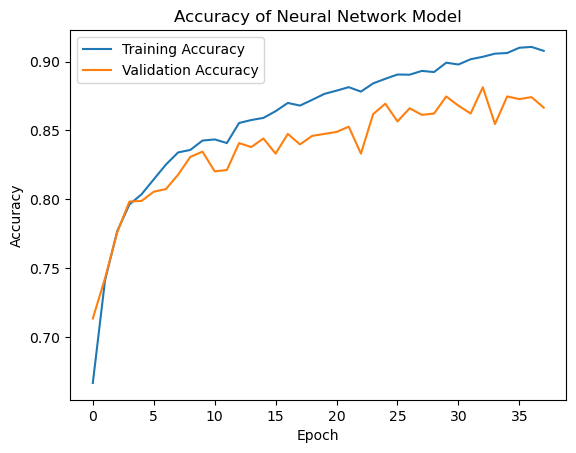

141/141 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2474
           1       0.86      0.85      0.86      2020

    accuracy                           0.87      4494
   macro avg       0.87      0.87      0.87      4494
weighted avg       0.87      0.87      0.87      4494



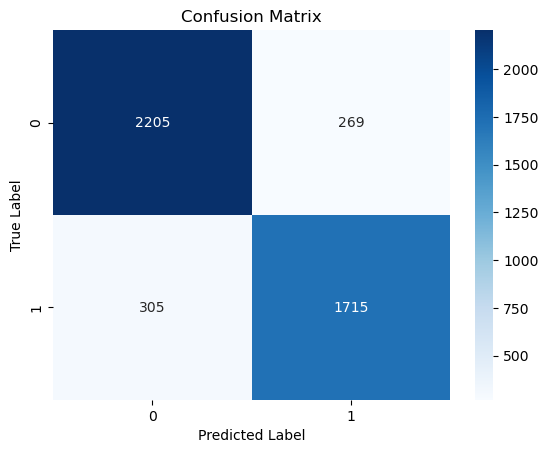

141/141 [==============================] - 0s 1ms/step - loss: 0.2835 - accuracy: 0.8723
Test Accuracy: 87.2274


In [49]:
build_and_fit_model(data, "State", 128)